# Проект: вариант 1

Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:

1. В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.
2. Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.
3. Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.

## Предобработка данных

In [125]:
import pandas as pd
import seaborn as sns
import numpy as np
import scipy.stats as ss

import warnings
warnings.filterwarnings('ignore')

In [126]:
reg_data = pd.read_csv('problem1-reg_data.csv', sep=';')
auth_data = pd.read_csv('problem1-auth_data.csv', sep=';')

auth_data['auth_dt'] = pd.to_datetime(pd.to_datetime(auth_data['auth_ts'], utc=True, unit='s').dt.strftime('%d-%m-%Y'))
reg_data['reg_dt'] = pd.to_datetime(pd.to_datetime(reg_data['reg_ts'], utc=True, unit='s').dt.strftime('%d-%m-%Y'))

reg_data = reg_data.sort_values('reg_dt')
auth_data = auth_data.sort_values('auth_dt')

In [127]:
reg_data.head()

,reg_ts,uid,reg_dt
0,911382223,1,1998-11-18
1,932683089,2,1999-07-22
2,947802447,3,2000-01-13
3,959523541,4,2000-05-28
4,969103313,5,2000-09-16


In [128]:
auth_data.head()

,auth_ts,uid,auth_dt
0,911382223,1,1998-11-18
11,936224929,2,1999-01-09
17,938759547,2,1999-01-10
33,944059661,2,1999-01-12
12,936369549,2,1999-03-09


In [129]:
reg_data.agg({'reg_dt': ['min', 'max']})

,reg_dt
min,1998-11-18
max,2020-12-09


In [130]:
auth_data.agg({'auth_dt': ['min', 'max']})

,auth_dt
min,1998-11-18
max,2020-12-09


In [131]:
auth_data.auth_dt.nunique()

6169

In [132]:
reg_data.reg_dt.nunique()

5110

In [133]:
auth_data

,auth_ts,uid,auth_dt
0,911382223,1,1998-11-18
11,936224929,2,1999-01-09
17,938759547,2,1999-01-10
33,944059661,2,1999-01-12
12,936369549,2,1999-03-09
...,...,...,...
9423856,1599897759,818035,2020-12-09
9423857,1599897762,577900,2020-12-09
9423858,1599897763,198638,2020-12-09
9423830,1599897614,403306,2020-12-09


## Задание 1. Расчет Retention Rate.

### 1.1 Первый способ, показывает динамику RR для введенной когорты пользователей.

In [134]:
def retention_rate(date):
    ##Отбираем данные из reg_data и auth_data
    sample_reg_data = reg_data.query('reg_dt == @date')
    sample_auth_data = auth_data.query('auth_dt >= @date')
    ##Считаем retention на каждый день для выбранной когорты
    total_users = len(sample_reg_data)
    retention_table = sample_reg_data.merge(sample_auth_data, on='uid', how='left') \
    .groupby('auth_dt', as_index=False) \
    .agg({'uid': 'count'}) \
    .assign(retention= lambda x: x.uid / total_users)
    return retention_table[['auth_dt', 'retention']]

In [135]:
retention_rate('2020-08-09')

,auth_dt,retention
0,2020-08-09,1.000000
1,2020-09-09,0.017456
2,2020-09-13,0.076060
3,2020-09-14,0.075436
4,2020-09-15,0.066085
5,2020-09-16,0.051746
6,2020-09-17,0.051746
7,2020-09-18,0.065461
8,2020-09-19,0.053616
9,2020-09-20,0.059227


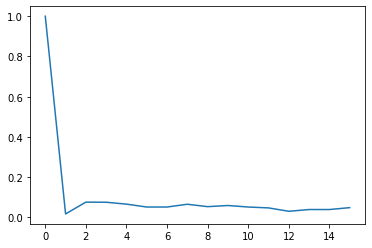

In [136]:
retention_rate('2020-08-09')['retention'].plot()

### 1.2 Второй способ, показывает показывает сводную таблицу и heatmap для всех когор начиная с введеной когорты пользователей. 

In [137]:
def retention_rate_map(date):
    #Отбираем данные из reg_data и auth_data
    sample_reg_data = reg_data.query('reg_dt >= @date')
    sample_auth_data = auth_data.query('auth_dt >= @date')
   
    #Создаем датафрейм с днями между минимальной датой захода и максимальной
    min_date = sample_auth_data.auth_dt.min()
    max_date = sample_auth_data.auth_dt.max()
    days = pd.DataFrame(pd.date_range(min_date, max_date, freq='d')).rename(columns={0: 'day'})
    
    #Объединяем таблицы reg_data и days по суррогатному ключу
    days['key'] = 1
    sample_reg_data['key'] = 1
    template = sample_reg_data.merge(days, on='key', how='left')[['uid','reg_dt', 'day']]
    template = template[template['day'] > template['reg_dt']]
    sample_auth_data['day'] = sample_auth_data['auth_dt']
    
    #Объединяем таблицы reg_data и auth_data
    report = template.merge(sample_auth_data, on=['uid', 'day'], how='left')[['uid', 'reg_dt', 'day', 'auth_dt']]
    report['active'] = report['auth_dt'].notna()*1
    
    #Создаем сводную таблицу, где индексы - даты регистрации, колонки - дни захода, значения - retention rate
    pivot = report.pivot_table(index='reg_dt', columns='day', values='active', aggfunc='mean')
    
    return pivot

In [138]:
retention_rate_map("2020-12-01")

day,2020-12-02,2020-12-03,2020-12-04,2020-12-05,2020-12-06,2020-12-07,2020-12-08,2020-12-09
reg_dt,,,,,,,,
2020-12-01,0.025902,0.014801,0.012951,0.017576,0.022202,0.013876,0.024052,0.013876
2020-12-02,NaN,0.029877,0.013181,0.013181,0.017575,0.011424,0.010545,0.014060
2020-12-03,NaN,NaN,0.029338,0.011735,0.012573,0.012573,0.011735,0.013412
2020-12-04,NaN,NaN,NaN,0.029459,0.019108,0.008758,0.007962,0.014331
2020-12-05,NaN,NaN,NaN,NaN,0.022745,0.014405,0.012130,0.013647
2020-12-06,NaN,NaN,NaN,NaN,NaN,0.031700,0.008646,0.012968
2020-12-07,NaN,NaN,NaN,NaN,NaN,NaN,0.039095,0.017147
2020-12-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.016949


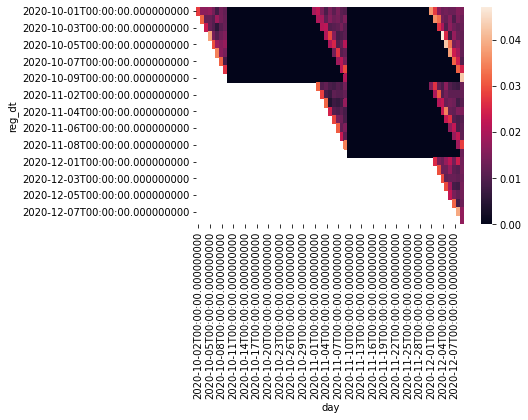

In [139]:
sns.heatmap(retention_rate_map("2020-10-01"))

### 1.3 Вывод: в данных наблюдается определнного рода цикличность)

## Задание 2
Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что **ARPU** в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? 
Какие метрики стоит проанализировать для принятия правильного решения и как?

### 2.1 Анализ реузльтатов

In [140]:
results = pd.read_csv('Проект_1_Задание_2.csv', sep=';')
results.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [141]:
results.groupby('testgroup', as_index=False).agg({'revenue': ['median', 'mean', 'sum', 'count']})

testgroup revenue                            
             median       mean      sum   count
0         a       0  25.413720  5136189  202103
1         b       0  26.751287  5421603  202667

Из-за большого кол-ва нулевого значения revenue, медиана принимает значение 0.
Поэтому в дальнейшем будем использовать пользователей, которые совершили хоть какую-то покупку.

In [142]:
results.query('testgroup == "a" and revenue > 0').revenue.describe()

count     1928.000000
mean      2663.998444
std       9049.039763
min        200.000000
25%        257.000000
50%        311.000000
75%        361.000000
max      37433.000000
Name: revenue, dtype: float64

In [143]:
results.query('testgroup == "b" and revenue > 0').revenue.describe()

count    1805.000000
mean     3003.658172
std       572.619709
min      2000.000000
25%      2513.000000
50%      3022.000000
75%      3478.000000
max      4000.000000
Name: revenue, dtype: float64

In [144]:
results.query('revenue > 0') \
    .groupby('testgroup', as_index=False) \
    .agg({'revenue': ['median', 'mean', 'sum', 'count']})

testgroup revenue                            
             median         mean      sum count
0         a     311  2663.998444  5136189  1928
1         b    3022  3003.658172  5421603  1805

Видим, что среднее значение и медиана различаются и у группу **b** оба показателя лучше. Кол-во платежеспособных клиентов в группе **b** меньше, но суммарно они принесли прибыль больше.

### 2.2 Посмотрим на распределение revenue в обоих группах

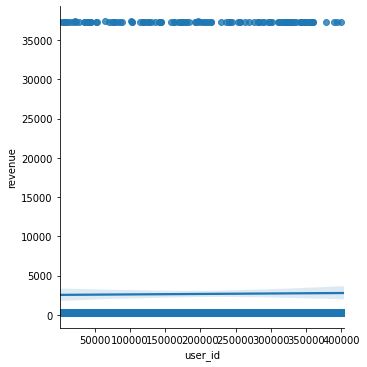

In [145]:
sns.lmplot(data=results.query('revenue > 0 and testgroup == "a"'), x='user_id', y='revenue')

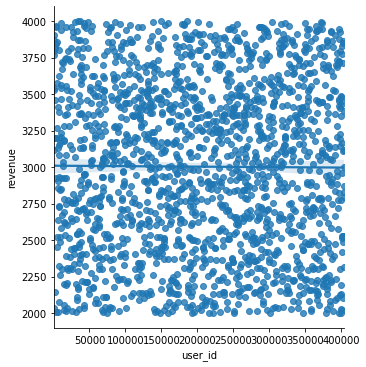

In [146]:
sns.lmplot(data=results.query('revenue > 0 and testgroup == "b"'), x='user_id', y='revenue')

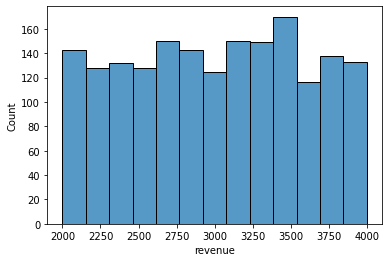

In [147]:
sns.histplot(results.query('revenue > 0 and testgroup == "b"').revenue)

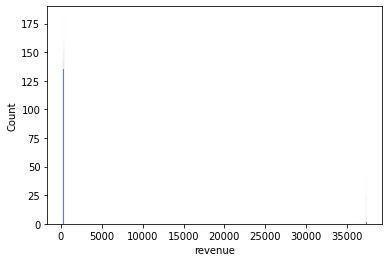

In [148]:
sns.histplot(results.query('revenue > 0 and testgroup == "a"').revenue)

### 2.3 Для проведения АБ-теста выберем и посчитаем метрики:
- ARPU (Average Revenue Per User)
- ARPPU (Average Revenue Per Paying User)
- CR (Conversion Rate в покупку)

#### 2.3.1 ARPU

Группа **a**

In [149]:
arpu_a = results.query('revenue > 0 and testgroup == "a"').revenue.sum() \
    / \
    results.query('testgroup == "a"').revenue.count()
arpu_a

25.413719736965806

Группа **b**

In [150]:
arpu_b = results.query('revenue > 0 and testgroup == "b"').revenue.sum() \
    / \
    results.query('testgroup == "b"').revenue.count()
arpu_b

26.75128659327863

Различия составляют **5%**

In [151]:
arpu_b / arpu_a - 1

0.05263168360069903

Проверим гипотезу:
- H0 : в группе a и группе b средние значения revenue не отличаются
- H1 : в группе a и группе b средние значения revenue отличаются.

Проверим нормальность распределения данных в обоих группах

In [152]:
import pingouin as pg
pg.normality(results.query('testgroup == "a"')['revenue'])

,W,pval,normal
revenue,0.008877,0.0,False


In [153]:
ss.normaltest(results.query('testgroup == "a"')['revenue'])

NormaltestResult(statistic=585152.7312728433, pvalue=0.0)

In [154]:
ss.normaltest(results.query('testgroup == "b"')['revenue'])

NormaltestResult(statistic=326622.39540856465, pvalue=0.0)

p < 0.05 значит мы отклоняем нулевую гипотезу о нормальности распределений данных внутри групп

Проверим однородность дисперсий внутри обоих групп

In [155]:
ss.levene(results.query('testgroup == "b"')['revenue'], 
          results.query('testgroup == "a"')['revenue'])

LeveneResult(statistic=0.3896289474701388, pvalue=0.5324948591043842)

p > 0.05 значит мы принимаем нулевую гипотезу о однородности дисперсий

Данные в обоих группах не имеют нормального распределения,но дисперсии одинаковы.
Будем использовать **t-test Стъюдента**

In [156]:
ss.ttest_ind(results.query('testgroup == "b"')['revenue'], 
             results.query('testgroup == "a"')['revenue'])

Ttest_indResult(statistic=0.6242026493616787, pvalue=0.532494858971837)

p > 0.05 => принимаем нулевую гипотезу, статистически значимые различия в средних значениях revenue между группами не обнаружены

#### 2.3.2 ARPPU

Группа **a**

In [157]:
arppu_a = results.query('revenue > 0 and testgroup == "a"').revenue.sum() \
    / \
    results.query('revenue > 0 and testgroup == "a"').revenue.count()
arppu_a

2663.9984439834025

Группа **b**

In [158]:
arppu_b = results.query('revenue > 0 and testgroup == "b"').revenue.sum() \
    / \
    results.query('revenue > 0 and testgroup == "b"').revenue.count()
arppu_b

3003.6581717451522

Различия составляют ~ **13%**

In [159]:
arppu_b / arppu_a - 1

0.12749997227996346

Проверим гипотезу:
- H0 : в группе a и группе b средние значения revenue не отличаются
- H1 : в группе a и группе b средние значения revenue отличаются.

In [160]:
ss.normaltest(results.query('revenue > 0 and testgroup == "a"')['revenue'])

NormaltestResult(statistic=1394.9457843086925, pvalue=1.2341605505935488e-303)

In [161]:
ss.normaltest(results.query('revenue > 0 and testgroup == "b"')['revenue'])

NormaltestResult(statistic=1068.8600084412267, pvalue=7.943249488371762e-233)

p < 0.05 значит мы отклоняем нулевую гипотезу о нормальности распределений данных внутри групп

Проверим однородность дисперсий внутри обоих групп

In [162]:
ss.levene(results.query('revenue > 0 and testgroup == "a"')['revenue'], 
          results.query('revenue > 0 and testgroup == "b"')['revenue'])

LeveneResult(statistic=80.85567421779912, pvalue=3.779689868667878e-19)

p < 0.05 значит мы отклоняем нулевую гипотезу о однородности дисперсий внутри наших групп

Данные в обоих группах не имеют нормального распределения,но дисперсии одинаковы.
Будем использовать **t-test Уэлча**

In [163]:
ss.ttest_ind(results.query('revenue > 0 and testgroup == "a"')['revenue'],
             results.query('revenue > 0 and testgroup == "b"')['revenue'],
             equal_var=False) 

Ttest_indResult(statistic=-1.6446302664300838, pvalue=0.10020780398916015)

p > 0.05 =>Принимаем нулевую гипотезу, статитические значимые различия отсутствуют.

#### 2.3.3 CR

Группа **a**

In [164]:
cr_a = results.query('revenue > 0 and testgroup == "a"').user_id.count() \
    / \
    results.query('testgroup == "a"').user_id.count()
cr_a

0.009539690157988749

Группа **b**

In [165]:
cr_b = results.query('revenue > 0 and testgroup == "b"').user_id.count() \
    / \
    results.query('testgroup == "b"').user_id.count()
cr_b

0.008906235351586593

Различия составляют **7%**

In [166]:
cr_a / cr_b - 1

0.07112486717401967

Проверим гипотезы:
- Н0 : в тестовой и контрольной группе значение CR не отличается.
- Н1 : в тестовой и контрольной группе значение CR отличается.

In [167]:
results['flag'] = results.revenue.apply(lambda x: x > 0)

In [168]:
results_pivot = results.groupby(['testgroup', 'flag'], as_index=False) \
    .agg({'revenue': 'count'}) \
    .pivot(index='flag', columns='testgroup', values='revenue')
results_pivot

testgroup,a,b
flag,,
False,200175,200862
True,1928,1805


In [169]:
_, pvalue, _, _ = ss.chi2_contingency(results_pivot)
pvalue

0.03647561892312613

Т.к. pvalue < 0.05, то отклоняем нулевую гипотезу, есть статитические значимые различии в CR в покупку между группами.

### 2.4 Вывод 
Проведенный анализ метрик ARPU, ARPPU показал отсутсвие статистически значимых различий в ARPU и ARPPU между группами a и b. Также были обнаружены статистически значимые различия в метрике CR между группами a и b. Поэтому, для принятия окончательного решения о выборе лучшего набора предложений, необходимо провести дополнительные проверки и возможно даже разделить пользователей на группы более корректно.

## Задание 3
1) В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

2) Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

### 3.1 С помощью каких метрик можно оценить результаты последнего прошедшего события?

1) Метрики DAU, WAU - могут показать общую динамику посещения игры, и я предполагаю, что в момент старта тематического события кол-во пользователей в день начнет увеличиваться. Однако, не факт, что игроки начали заходить только из-за ивента, может быть есть иной фактор, который мы не учитываем.

2) Среднее кол-во пройденных уровней в день пользователем. Т.к. для получения награды необходимо пройти ряд уровней, то эта метрика покажет, насколько у пользователей повышается вовлеченность в игру.

3) Кол-во пользователей, которых удалось вернуть в игру благодаря ивенту. Зачастую о таких событиях узнать благодаря push-уведомлению, а значит, если ты давно не заходил в игру и тебе приходит push, то есть вероятность, что ты перейдешь по push-у.

4) Кол-во пользователей получивших уникальную награду / Общее кол-во пользователей. Здесь мы сможем увидеть, а на сколько юзеры заинтересованы в таких ивентах.

5) Деньги принесенные игроками за ивент.

### 3.2 Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

1) На мой взгляд можно использовать все те же метрики. 

2) Очевидно, что часть пользователей будет отваливаться, после каких-то уровней и не будут хотеть терять прогресс. Поэтому важно после ивента найти те уровни, которые оказались самыми сложными для игроков и возможно упростить их.